# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to default.

## Import Module

In [1]:
# Import module
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
import pydotplus

## Load Data

In [2]:
loans = pd.read_csv("lending-club-data.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [3]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

Here, we see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc. Let's take a look at the distribution of loan grades in the dataset.

In [4]:
pd.DataFrame(loans['grade'])

,grade
0,B
1,C
2,C
3,C
4,A
5,E
6,F
7,B
8,C
9,B


We can see that over half of the loan grades are assigned values B or C. Each loan is assigned one of these grades, along with a more finely discretized feature called subgrade (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information can be found [here](https://www.lendingclub.com/public/rates-and-fees.action).

Now, let's look at a different feature.

In [5]:
pd.DataFrame(loans['home_ownership'])

,home_ownership
0,RENT
1,RENT
2,RENT
3,RENT
4,RENT
5,RENT
6,OWN
7,RENT
8,OWN
9,OWN


This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home.

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called bad_loans. In this column **1** means a risky (bad) loan **0** means a safe loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

* +1 as a safe loan,
* -1 as a risky (bad) loan.

We put this in a new column called safe_loans.

In [6]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: 1 if x==0 else -1)
loans = loans.drop('bad_loans',1)

Now, let us explore the distribution of the column safe_loans. This gives us a sense of how many safe and risky loans are present in the dataset.

In [7]:
# Let's explore the distribution of safeloans
print("Number of safe loans: ", sum(loans['safe_loans']==1))
print("Number of bad loans: ", sum(loans['safe_loans']==-1))
print("Total number of loans: ", len(loans))

Number of safe loans:  99457
Number of bad loans:  23150
Total number of loans:  122607


## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [8]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature and target columns
loans = loans[features+[target]]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook.

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans. Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

In [9]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]

Now, write some code to compute below the percentage of safe and risky loans in the dataset and validate these numbers against what was given using .show earlier in the assignment:

In [10]:
print("Percentage of safe loans: ", len(safe_loans_raw)/(len(safe_loans_raw)+len(risky_loans_raw)))

Percentage of safe loans:  0.8111853319957262


In [11]:
print("Percentage of risky loans: ", len(risky_loans_raw)/(len(safe_loans_raw)+len(risky_loans_raw)))

Percentage of risky loans:  0.18881466800427382


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used seed=1 so everyone gets the same results.

In [12]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

## Load Train-Validation Data

In [13]:
## Load index of train & validation
train_idx = pd.read_json("train-idx.json")
validation_idx = pd.read_json("validation-idx.json")
train_data = loans.iloc[train_idx[0].values]
validation_data = loans.iloc[validation_idx[0].values]

## One-hot Encoding

 For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding. 

First, let's explore data types of train data:

In [14]:
train_data.dtypes

grade                     object
sub_grade                 object
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
term                      object
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
safe_loans                 int64
dtype: object

We have to make categorical variables to binary features. We will call these features as `categorical_variables`:

In [15]:
categorical_variables = ['grade','sub_grade','home_ownership','purpose','term']

Now, we will encode `train_data` to binary features by using `get_dummies` function form `pandas`.

In [16]:
train_one_hot_encoded = pd.get_dummies(train_data,columns=categorical_variables)
train_target = train_one_hot_encoded['safe_loans']
train_features = train_one_hot_encoded.drop('safe_loans',axis = 1)

## Use decision tree to build a classifier

Let's build decision tree thorugh built-in `sklearn.tree.DecisionTreeClassifier`. Make classifier with **maximum depth of 6** and name it a `decision_tree_model`:

In [17]:
decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model = decision_tree_model.fit(train_features,train_target)

Also, train a tree with **maximum depth of 4** and name it a `small_model`.

In [18]:
small_model = DecisionTreeClassifier(max_depth=4)
small_model = small_model.fit(train_features,train_target)

## Visualizing a learned model

**Important: [Anaconda with Windows environment only]**

Following code is to correct wrong package path of [graphviz package](http://www.graphviz.org/Download_windows.php).

In [19]:
import sys
import os
def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths) 

Small Tree model:

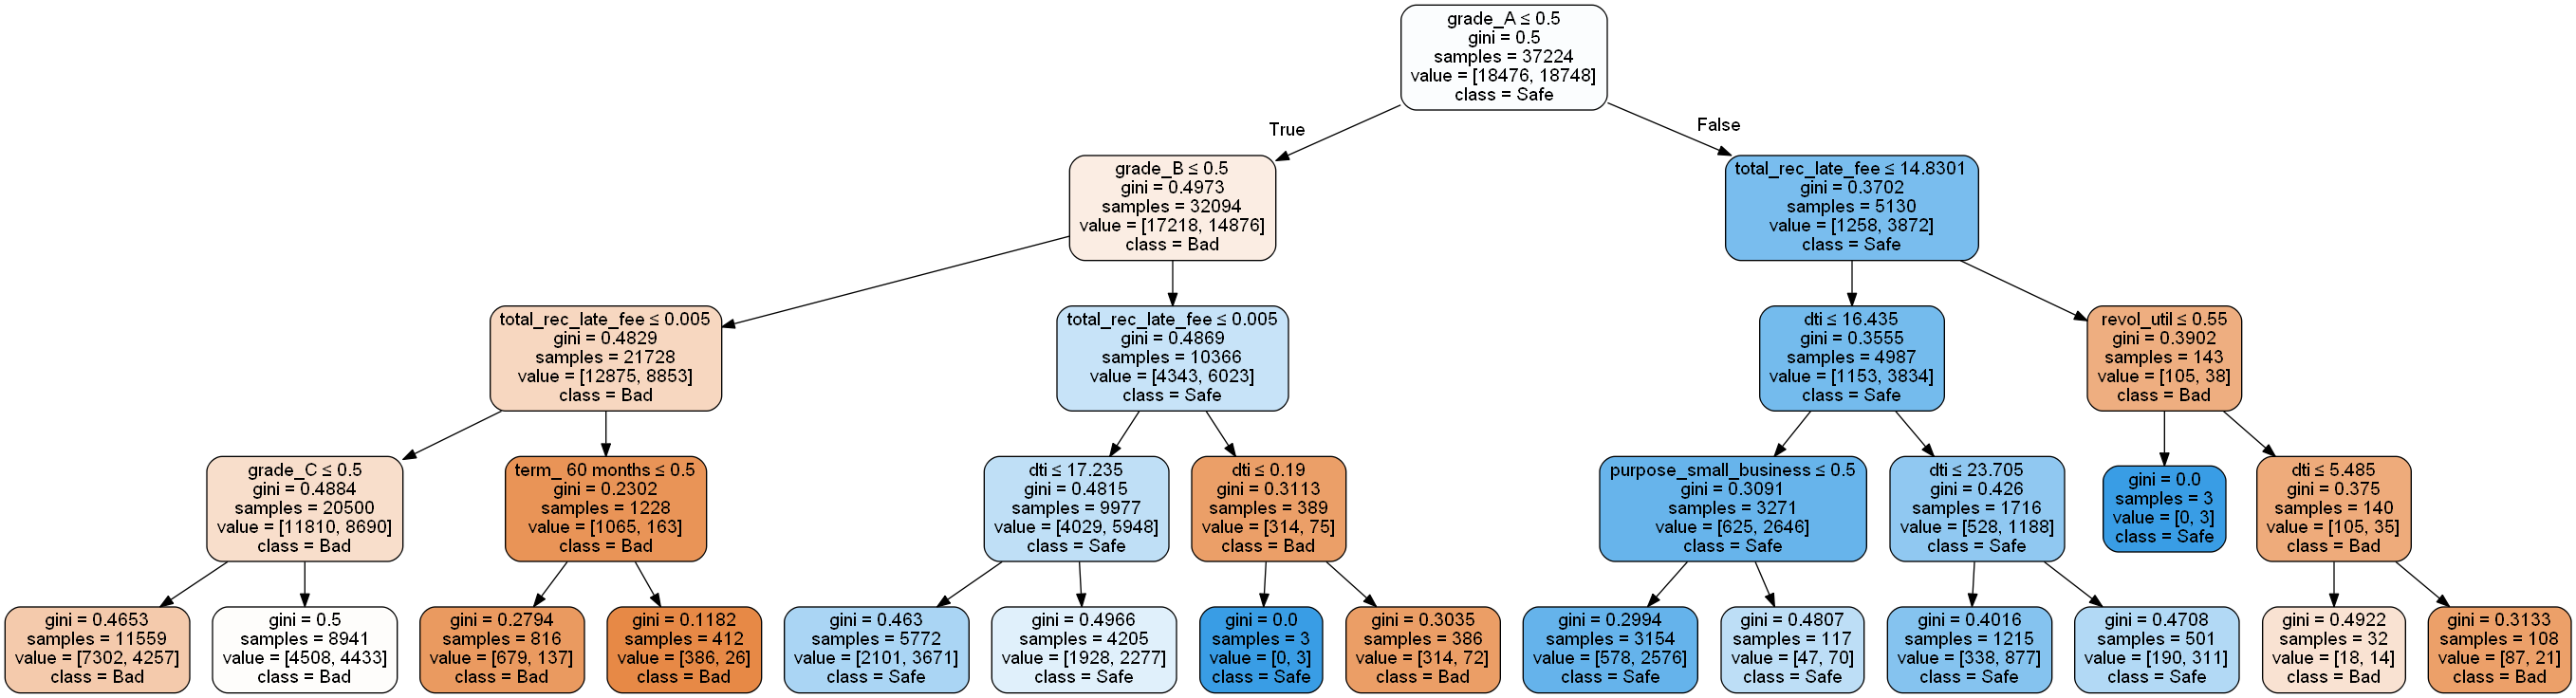

In [20]:
dot_data = export_graphviz(small_model,out_file=None,feature_names= train_features.columns.values, class_names=['Bad','Safe'],filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
conda_fix(graph)
display(Image(graph.create_png()))

## Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:

* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [21]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
19,B,B3,0,11,OWN,11.18,credit_card,36 months,1,1,82.4,0.0,1
79,D,D1,0,10,RENT,16.85,debt_consolidation,36 months,1,1,96.4,0.0,1
24,D,D2,0,3,RENT,13.97,other,60 months,0,1,59.5,0.0,-1
41,A,A5,0,11,MORTGAGE,16.33,debt_consolidation,36 months,1,1,62.1,0.0,-1


## Explore label predictions & probability predictions

Now, we will use our model to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_mode**l to predict whether or not the loan is classified as a **safe loan**.

In [22]:
# one-hot encoding
validation_one_encoded = pd.get_dummies(validation_data,columns=categorical_variables)
validation_features = validation_one_encoded.drop('safe_loans',axis=1)

In [23]:
# input
sample_validation_features = validation_features.loc[sample_validation_data.index]

In [24]:
# prediction
print("Predictions with max_depth = 6 (Class): ", decision_tree_model.predict(sample_validation_features))
print("Predictions with max_depth = 6 (Prob): ")
decision_prob = pd.DataFrame(decision_tree_model.predict_proba(sample_validation_features))
decision_prob = decision_prob.rename(columns={0:'RISKY',1:'SAFE'})
decision_prob

Predictions with max_depth = 6 (Class):  [ 1 -1 -1  1]
Predictions with max_depth = 6 (Prob): 


,RISKY,SAFE
0,0.341565,0.658435
1,0.536306,0.463694
2,0.647510,0.352490
3,0.207895,0.792105


Let's do same things to `small_model`:

In [25]:
print("Predictions with max_depth = 4 (Class): ", small_model.predict(sample_validation_features))
print("Predictions with max_depth = 4 (Prob): \n")
small_prob = pd.DataFrame(small_model.predict_proba(sample_validation_features))
small_prob = small_prob.rename(columns={0:'RISKY',1:'SAFE'})
small_prob

Predictions with max_depth = 4 (Class):  [ 1 -1 -1  1]
Predictions with max_depth = 4 (Prob): 



,RISKY,SAFE
0,0.363999,0.636001
1,0.631716,0.368284
2,0.631716,0.368284
3,0.183259,0.816741


## Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows: 

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the **training data**.

In [26]:
print("Accuracy (Depth: 6, TRAIN DATA): %.4g" %decision_tree_model.score(train_features,train_data['safe_loans']))
print("Accuracy (Depth: 4, TRAIN DATA): %.4g" %small_model.score(train_features,train_data['safe_loans']))

Accuracy (Depth: 6, TRAIN DATA): 0.6405
Accuracy (Depth: 4, TRAIN DATA): 0.6201


Now, let us evaluate the accuracy of the `small_model` and `decision_tree_model` on the **entire validation_data**.

In [27]:
print("Accuracy (Depth: 6, VALIDATION DATA): %.4g" %decision_tree_model.score(validation_features,validation_data['safe_loans']))
print("Accuracy (Depth: 4, VALIDATION DATA): %.4g" %small_model.score(validation_features,validation_data['safe_loans']))

Accuracy (Depth: 6, VALIDATION DATA): 0.6361
Accuracy (Depth: 4, VALIDATION DATA): 0.6249


## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [28]:
big_model = DecisionTreeClassifier(max_depth=10)
big_model = big_model.fit(train_features,train_target)

Now, let us evaluate `big_model` on the training set and validation set.

In [29]:
print("=====TREE MODEL WITH DEPTH OF 10=====")
print("Accuracy (Depth: 10, TRAIN DATA): %.4g" %big_model.score(train_features,train_data['safe_loans']))
print("Accuracy (Depth: 10, VALIDATION DATA): %.4g" %big_model.score(validation_features,validation_data['safe_loans']))

=====TREE MODEL WITH DEPTH OF 10=====
Accuracy (Depth: 10, TRAIN DATA): 0.6637
Accuracy (Depth: 10, VALIDATION DATA): 0.626


### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted.
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given.
* **Correct predictions**: All correct predictions don't typically incur any cost.

Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:

1. First, let us compute the predictions made by the model.
2. Second, compute the number of false positives.
3. Third, compute the number of false negatives.
4. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

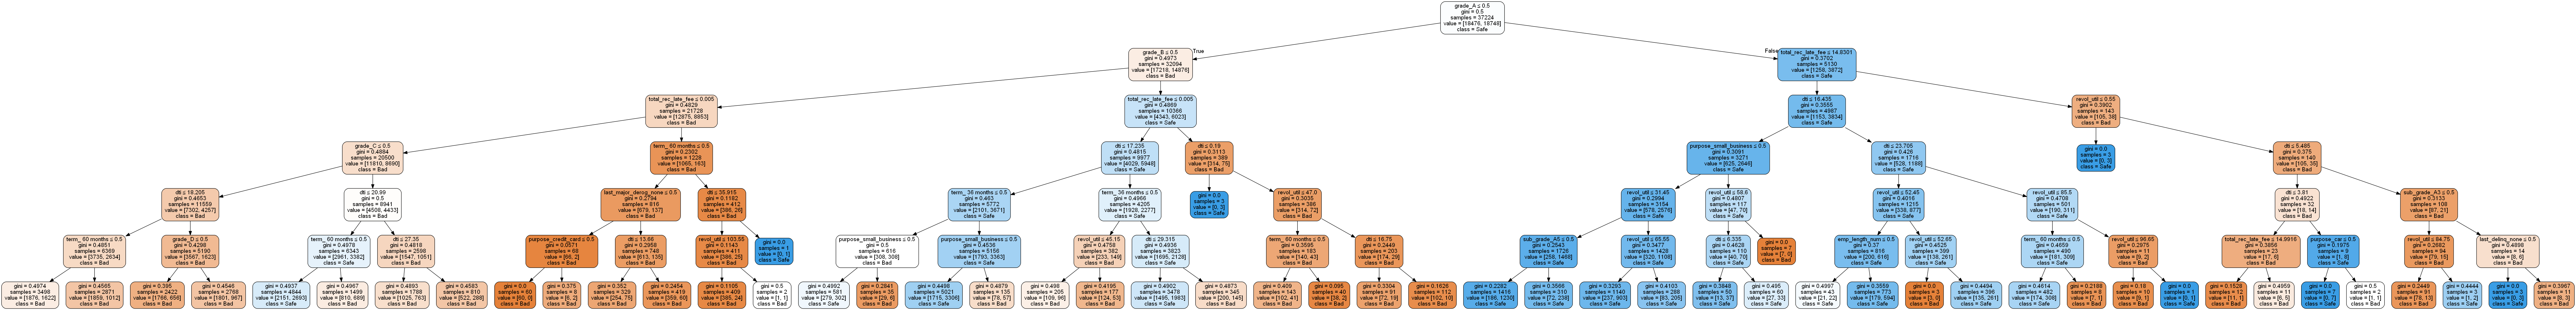

In [30]:
predictions = decision_tree_model.predict(validation_features)
dot_data = export_graphviz(decision_tree_model,out_file=None,feature_names= validation_features.columns.values, class_names=['Bad','Safe'],filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
conda_fix(graph)
display(Image(graph.create_png()))

In [31]:
print("Number of Samples: ", len(predictions))
false_positives = (validation_data[validation_data['safe_loans'] != predictions]['safe_loans'] == -1).sum()
false_negatives = (validation_data[validation_data['safe_loans'] != predictions]['safe_loans'] == +1).sum()
print("FALSE Positive: ", false_positives)
print("FALSE Negative: ", false_negatives)

Number of Samples:  9284
FALSE Positive:  1661
FALSE Negative:  1717


Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

In [32]:
# Assume a cost of \$10,000 per false negative.
# Assume a cost of \$20,000 per false positive.
cost_of_mistakes = (false_negatives * 10000) + (false_positives * 20000)
print("Cost of Mistakes: ", cost_of_mistakes)

Cost of Mistakes:  50390000
